In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Pre-processing

In [2]:
# all_train = pd.read_csv("datasets/toxic_train.csv")

In [3]:
# filter only toxic comments and convert comment_text to str

# toxic_only_train = all_train[all_train["target"] >= 0.5]
# toxic_only_train['comment_text'] = toxic_only_train['comment_text'].astype(str)

In [4]:
# shortlist only columns of interest only as well

# temp = toxic_only_train.iloc[:, :-13]
# toxic_only_train_shortlisted = temp.drop(temp.columns[[0, 1, 3, 4, 5, 6, 7]], axis = 1)
# toxic_only_train_shortlisted.head()

In [5]:
# assuming that if NaN for any category, probability of category = 0

# toxic_only_train_shortlisted.fillna(0, inplace = True)
# toxic_only_train_shortlisted.head()

In [6]:
# sum values for race, gender, religion and disabilities

# toxic_only_train_shortlisted["Race"] = toxic_only_train_shortlisted[["black", "white", "asian", "latino", "other_race_or_ethnicity"]].sum(axis = 1)
# toxic_only_train_shortlisted["Gender"] = toxic_only_train_shortlisted[["male", "female", "transgender", "other_gender", "heterosexual", "homosexual_gay_or_lesbian", "bisexual", "other_sexual_orientation"]].sum(axis = 1)
# toxic_only_train_shortlisted["Religion"] = toxic_only_train_shortlisted[["christian", "jewish", "muslim", "hindu", "atheist", "other_religion"]].sum(axis = 1)
# toxic_only_train_shortlisted["Disability"] = toxic_only_train_shortlisted[["intellectual_or_learning_disability", "other_disability", "physical_disability", "psychiatric_or_mental_illness"]].sum(axis = 1)

In [7]:
# drop identity columns after

# toxic_only_train_shortlisted.drop(toxic_only_train_shortlisted.iloc[:, 1:25], inplace = True, axis = 1)

In [8]:
# if all identities are 0, we will assume that attacks were not directed to any in particular and hence "None"

# toxic_only_train_shortlisted["target"] = np.where(toxic_only_train_shortlisted.iloc[:, 1:5].max(axis = 1) > 0, toxic_only_train_shortlisted.iloc[:, 1:5].idxmax(axis = 1), "None")

In [9]:
# drop sum columns for all identities

# toxic_only_train_shortlisted.drop(toxic_only_train_shortlisted.iloc[:, 1:5], inplace = True, axis = 1)

In [2]:
# preprocess text
# keep asterisks as they may be used to censor vulgar words

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import nltk
import re

# nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocesstext(text):
    text = text.lower() # convert everything to lower case first
    text = re.sub('(?:(?!\*)(?!\*)(?![a-zA-Z0-9]).)', ' ', text) # Removes special characters (except asterisk) and punctuations
    words = word_tokenize(text)
    words_without_stopwords = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    text = " ".join(words_without_stopwords)
    return text

In [3]:
# toxic_only_train_shortlisted["preprocessed_text"] = toxic_only_train_shortlisted["comment_text"].apply(preprocesstext)

In [4]:
# save files so that there's no need to preprocess again

# toxic_only_train_shortlisted.to_pickle('toxic_only_train_shortlisted_preprocessed.pkl')

In [2]:
# load preprocessed file

toxic_only_train_shortlisted = pd.read_pickle('toxic_only_train_shortlisted_preprocessed.pkl')

# Classification Models (Task 1)

In [6]:
from sklearn.model_selection import train_test_split

X = toxic_only_train_shortlisted["preprocessed_text"]
y = toxic_only_train_shortlisted["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train)
tfidf_test = tfidf_vec.transform(X_test)

In [16]:
# install yellowbrick for AUC ROC plot for multiclass

# !pip install yellowbrick

In [17]:
# for evaluation of performance

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [18]:
# to facilitate the plotting of ROCAUC curve

from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, classes=['Race', 'Gender', 'Religion', 'Disability', 'None'])
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

**Logistic Regression**

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
logreg = LogisticRegression(C = 5, random_state = 42, solver = 'sag', max_iter = 1000, n_jobs = -1)
logreg.fit(tfidf_train, y_train)
y_pred = logreg.predict(tfidf_test)

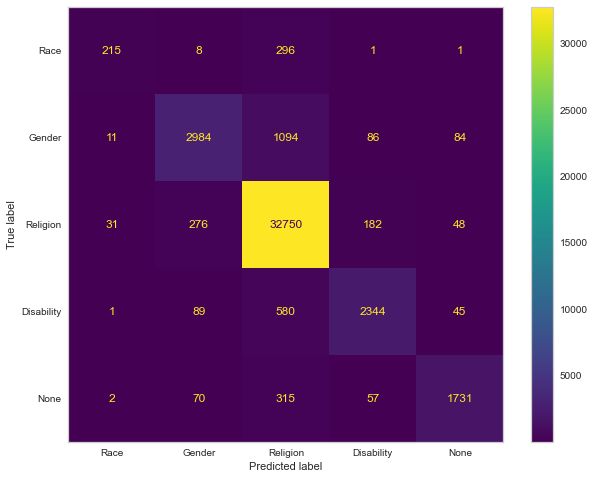

In [21]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(mat, display_labels=["Race", "Gender", "Religion", "Disability", "None"])
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Disability       0.83      0.41      0.55       521
      Gender       0.87      0.70      0.78      4259
        None       0.93      0.98      0.96     33287
        Race       0.88      0.77      0.82      3059
    Religion       0.91      0.80      0.85      2175

    accuracy                           0.92     43301
   macro avg       0.88      0.73      0.79     43301
weighted avg       0.92      0.92      0.92     43301



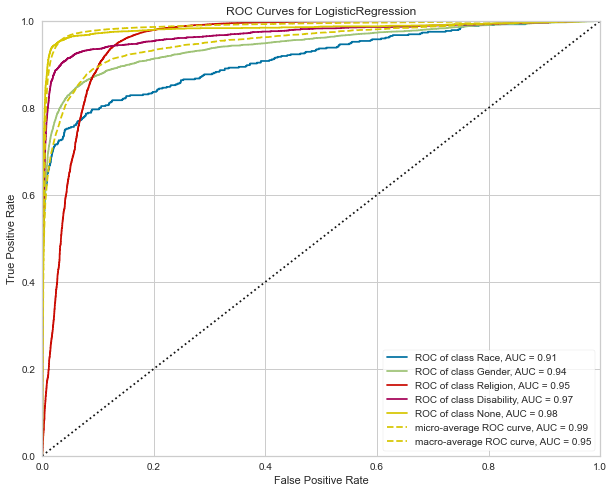

In [23]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(logreg, tfidf_train, y_train, tfidf_test, y_test)
plt.show()

# LDA (Task 2)

In [3]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

**LDA Pre-Processing**

In [4]:
def lda_preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS:
            result.append(token)
    return result

In [5]:
lda_preprocessed_comments = toxic_only_train_shortlisted['preprocessed_text'].map(lda_preprocess)

**Gensim**

In [6]:
dictionary = corpora.Dictionary(lda_preprocessed_comments)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=75000)

In [7]:
bow_corpus = [dictionary.doc2bow(doc) for doc in lda_preprocessed_comments]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [8]:
lda_model = models.LdaMulticore(corpus_tfidf, num_topics=20,
                                    id2word=dictionary, passes=2, workers=2)

In [9]:
topics = lda_model.print_topics(num_words=5)
for i, topic in enumerate(topics[:10]):
    print("Train topic {}: {}".format(i, topic))

Train topic 0: (0, '0.011*"rubbish" + 0.007*"lame" + 0.006*"uranium" + 0.006*"pervert" + 0.006*"hollywood"')
Train topic 1: (1, '0.020*"idiot" + 0.009*"trump" + 0.008*"ridiculous" + 0.008*"pig" + 0.008*"buffoon"')
Train topic 2: (2, '0.011*"priest" + 0.009*"bishop" + 0.009*"suck" + 0.007*"blah" + 0.006*"gross"')
Train topic 3: (3, '0.011*"canadian" + 0.009*"korea" + 0.008*"north" + 0.007*"china" + 0.007*"shut"')
Train topic 4: (4, '0.014*"nfl" + 0.010*"dumb" + 0.007*"lock" + 0.006*"dumber" + 0.005*"bc"')
Train topic 5: (5, '0.004*"trump" + 0.004*"na" + 0.004*"people" + 0.004*"like" + 0.003*"gon"')
Train topic 6: (6, '0.010*"black" + 0.008*"pathetic" + 0.006*"cretin" + 0.006*"white" + 0.005*"racist"')
Train topic 7: (7, '0.005*"mentally" + 0.005*"dp" + 0.005*"player" + 0.005*"ill" + 0.005*"team"')
Train topic 8: (8, '0.014*"liar" + 0.012*"trump" + 0.008*"lie" + 0.007*"fool" + 0.006*"left"')
Train topic 9: (9, '0.005*"cat" + 0.005*"stink" + 0.004*"sa" + 0.004*"moore" + 0.004*"dog"')


In [10]:
# predict the type of topic for document (index 5)

bd5 = bow_corpus[5]
for i in range(len(bd5)):
    print("Word {} (\"{}\") appears {} time.".format(bd5[i][0], dictionary[bd5[i][0]],bd5[i][1]))

Word 50 ("act") appears 1 time.
Word 51 ("bash") appears 1 time.
Word 52 ("christian") appears 1 time.
Word 53 ("entire") appears 1 time.
Word 54 ("idiot") appears 1 time.
Word 55 ("muslim") appears 1 time.
Word 56 ("okay") appears 2 time.
Word 57 ("religion") appears 1 time.
Word 58 ("sect") appears 1 time.
Word 59 ("smear") appears 1 time.


In [11]:
for index, score in sorted(lda_model[bd5], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 5)))


Score: 0.5126560926437378	 
Topic: 0.016*"muslim" + 0.014*"white" + 0.012*"terrorist" + 0.011*"nazi" + 0.008*"supremacist"

Score: 0.3351171612739563	 
Topic: 0.018*"troll" + 0.011*"disgusting" + 0.007*"draft" + 0.007*"anc" + 0.005*"trump"

Score: 0.08137363195419312	 
Topic: 0.005*"mentally" + 0.005*"dp" + 0.005*"player" + 0.005*"ill" + 0.005*"team"


In [12]:
# the lower the better
print('Perplexity: ', round(lda_model.log_perplexity(bow_corpus), 2))

# the higher the better
coherence_model_lda = models.CoherenceModel(model=lda_model, texts=lda_preprocessed_comments, 
                                     dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Perplexity:  -9.1

Coherence Score:  0.4306023847201753


In [13]:
lda_vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
lda_vis

C:\Users\DVH\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.083803  0.076020       1        1  13.223912
17     0.054457 -0.028159       2        1  13.083750
12     0.041341 -0.109395       3        1  10.979954
10     0.040738 -0.013303       4        1   7.883665
14     0.018780 -0.109981       5        1   5.963966
5      0.037618 -0.007850       6        1   5.283582
8      0.031296 -0.035964       7        1   5.111289
19     0.029312 -0.005359       8        1   4.982280
11     0.024917 -0.013722       9        1   3.929514
3      0.040878  0.131796      10        1   3.593007
16     0.011153 -0.052667      11        1   3.587650
1      0.001767 -0.060258      12        1   3.114294
9      0.017934  0.121774      13        1   2.980920
6      0.014301 -0.075165      14        1   2.938470
7      0.011839 -0.053021      15        1   2.904082
15    -0.007273 -0.054433      16        1   2.679263
4      0.028814  0.130700      17        1   2.667427
13    -0.006822  0.135535      18        1   2.061723
2     -0.248123 -0.052258      19        1   1.596352
0     -0.226731  0.075712      20        1   1.434902, topic_info=          Term         Freq        Total Category  logprob  loglift
54       idiot  8014.000000  8014.000000  Default  30.0000  30.0000
55      muslim  4203.000000  4203.000000  Default  29.0000  29.0000
45       troll  3492.000000  3492.000000  Default  28.0000  28.0000
2761  canadian  2934.000000  2934.000000  Default  27.0000  27.0000
765        tax  5160.000000  5160.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1688     scary   128.144335   376.035821  Topic20  -5.8250   3.1675
2215   twisted   119.544974   354.321553  Topic20  -5.8945   3.1576
4165     creep   113.876108   278.784521  Topic20  -5.9431   3.3487
210       pile   117.015959   480.375345  Topic20  -5.9159   2.8318
2761  canadian   126.188792  2934.902974  Topic20  -5.8404   1.0974

[1506 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
4751       6  0.009049          aa
4751      17  0.950174          aa
4848      16  0.937608   abhorrent
8404       3  0.961796       abide
12944      9  0.966103  aboriginal
...      ...       ...         ...
6728       3  0.007793     youtube
6728       4  0.941061     youtube
6728       6  0.007793     youtube
6728       9  0.001948     youtube
9595      14  0.918970        yuck

[7513 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 18, 13, 11, 15, 6, 9, 20, 12, 4, 17, 2, 10, 7, 8, 16, 5, 14, 3, 1])

In [ ]:
# find optimal k (no. of topics) and plot graph visually



**Sklearn**

In [14]:
lda_comments_joined = [" ". join(x) for x in list(lda_preprocessed_comments)]

In [15]:
# TFIDF numerical representation
tfidf_vectoriser = TfidfVectorizer()
lda_tfidf_vecs = tfidf_vectoriser.fit_transform(lda_comments_joined)

# Count numerical representation
count_vectoriser = CountVectorizer()
lda_count_vecs = count_vectoriser.fit_transform(lda_comments_joined)

In [16]:
# LDA based on TFIDF (use this first because of the similar TFIDF representation used for Gensim)

LDA_tfidf = LatentDirichletAllocation(n_jobs = -1)
LDA_tfidf.fit(lda_tfidf_vecs)

LatentDirichletAllocation(n_jobs=-1)

In [17]:
# LDA based on count

LDA_count = LatentDirichletAllocation(n_jobs = -1)
LDA_count.fit(lda_count_vecs)

LatentDirichletAllocation(n_jobs=-1)